In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn

import logging
logging.basicConfig(level=logging.INFO)

from robo.initial_design.init_random_uniform import init_random_uniform

seaborn.set_style(style='whitegrid')

plt.rc('text', usetex=True)
plt.rc('font', size=15.0, family='serif')
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

# Model

In [13]:
def objective(x, task):
    if task == 0:
        y = 0.5 * np.sin(3 * x[0]) * 4 * (x[0] - 1) * (x[0] + 2)
    elif task == 1:
        y = np.sin(3 * x[0]) * 4 * (x[0] - 1) * (x[0] + 2)
    return y

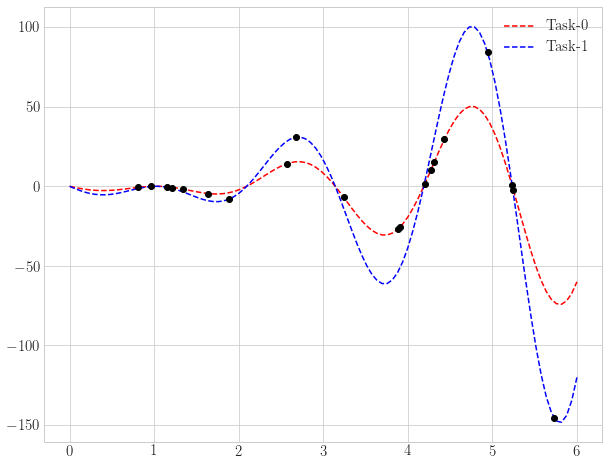

In [14]:
grid = np.linspace(0, 6, 100)

f_t0 = np.array([objective(np.array([[xi]]), 0) for xi in grid])
f_t1 = np.array([objective(np.array([[xi]]), 1) for xi in grid])

plt.plot(grid, f_t0, "r--", label="Task-0")
plt.plot(grid, f_t1, "b--", label="Task-1")

lower = np.zeros(1)
upper = np.ones(1) * 6

X = init_random_uniform(lower, upper, 20)
y_t0 = np.array([objective(xi, 0) for xi in X[:15]])
y_t1 = np.array([objective(xi, 1) for xi in X[15:]])
y = np.hstack((y_t0, y_t1))

t_idx = np.zeros([20])
t_idx[15:] = 1 

plt.plot(X, y, "ko")

X = np.append(X, t_idx[:, None], axis=1)


plt.legend()
plt.show() 

In [15]:
import george
from robo.models.mtbo_gp import MTBOGPMCMC
from robo.priors.env_priors import MTBOPrior

# Define model for the objective function
cov_amp = 1  # Covariance amplitude
n_dims = 1
n_tasks = 2
n_hypers = 20
chain_length = 200
burnin = 100
kernel = cov_amp

# ARD Kernel for the configuration space
for d in range(n_dims):
    kernel *= george.kernels.Matern52Kernel(np.ones([1]) * 0.01,
                                            ndim=n_dims+1, dim=d)

task_kernel = george.kernels.TaskKernel(n_dims+1, n_dims, n_tasks)
kernel *= task_kernel

# Take 3 times more samples than we have hyperparameters
if n_hypers < 2*len(kernel):
    n_hypers = 3 * len(kernel)
    if n_hypers % 2 == 1:
        n_hypers += 1

prior = MTBOPrior(len(kernel) + 1,
                  n_ls=n_dims,
                  n_kt=len(task_kernel))

model = MTBOGPMCMC(kernel, prior=prior,
                             burnin_steps=burnin,
                             chain_length=chain_length,
                             n_hypers=n_hypers,
                             lower=lower,
                             upper=upper)

In [16]:
model.train(X, y)

X_test = np.append(grid[:, None], np.zeros([grid.shape[0], 1]), axis=1)

mean_pred_t0, var_pred = model.predict(X_test)
std_pred_t0 = np.sqrt(var_pred)

X_test = np.append(grid[:, None], np.ones([grid.shape[0], 1]), axis=1)

mean_pred_t1, var_pred = model.predict(X_test)
std_pred_t1 = np.sqrt(var_pred)

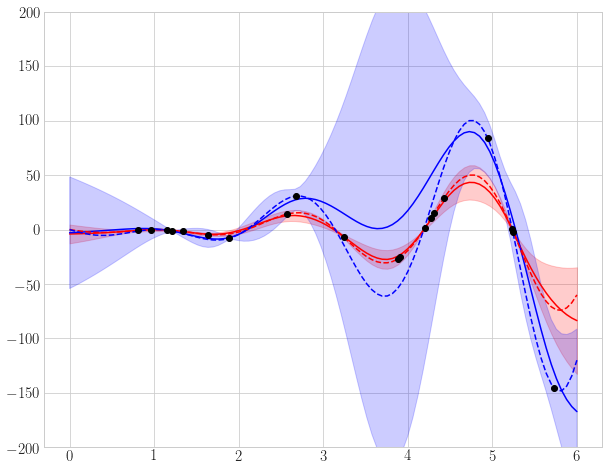

In [17]:
plt.plot(grid, mean_pred_t0, label="Model", color="red")
plt.fill_between(grid, mean_pred_t0 + std_pred_t0, mean_pred_t0 - std_pred_t0, alpha=0.2, color="red")

plt.plot(grid, mean_pred_t1, label="Model", color="blue")
plt.fill_between(grid, mean_pred_t1 + std_pred_t1, mean_pred_t1 - std_pred_t1, alpha=0.2, color="blue")


plt.plot(grid, f_t0, "r--", label="Task-0")
plt.plot(grid, f_t1, "b--", label="Task-1")
plt.ylim(-200, 200)
plt.plot(X[:, 0], y, "ko")
plt.show()

# Warmstarting BO

In [5]:
from robo.fmin.warmstart_mtbo import warmstart_mtbo

res = warmstart_mtbo(objective_function=objective,
                      lower=lower, upper=upper, observed_X=X[:15].tolist(), observed_y=y[:15].tolist(), num_iterations=10)

INFO:robo.fmin.warmstart_mtbo:Start iteration 2 ... 
INFO:robo.fmin.warmstart_mtbo:Current incumbent [5.38628237 1.        ] with estimated performance -28.235862
INFO:robo.fmin.warmstart_mtbo:Optimization overhead was 3.111004 seconds
INFO:robo.fmin.warmstart_mtbo:Evaluate candidate [5.99994919 1.        ]
INFO:robo.fmin.warmstart_mtbo:Configuration achieved a performance of -120.172077
INFO:robo.fmin.warmstart_mtbo:Evaluation of this configuration took 0.000033 seconds
INFO:robo.fmin.warmstart_mtbo:Start iteration 3 ... 
INFO:robo.fmin.warmstart_mtbo:Current incumbent [5.99994919 1.        ] with estimated performance -120.172077
INFO:robo.fmin.warmstart_mtbo:Optimization overhead was 2.102281 seconds
INFO:robo.fmin.warmstart_mtbo:Evaluate candidate [4.89269928 1.        ]
INFO:robo.fmin.warmstart_mtbo:Configuration achieved a performance of 92.002025
INFO:robo.fmin.warmstart_mtbo:Evaluation of this configuration took 0.000017 seconds
INFO:robo.fmin.warmstart_mtbo:Start iteration 4 .

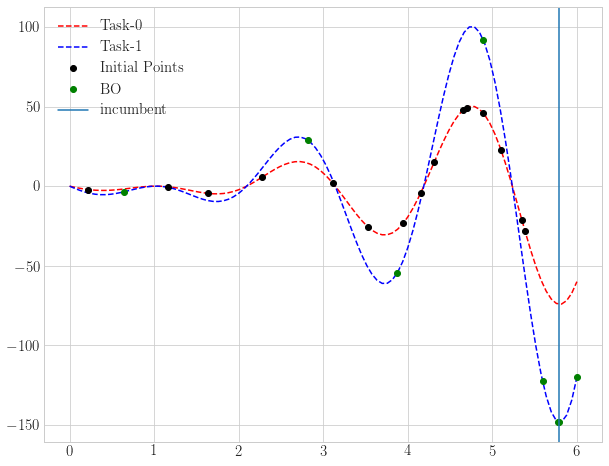

In [12]:
plt.plot(grid, f_t0, "r--", label="Task-0")

plt.plot(grid, f_t1, "b--", label="Task-1")

plt.plot(res["X"][:15, 0], res["y"][:15], "ko", label="Initial Points")

plt.plot(res["X"][15:, 0], res["y"][15:], "go", label="BO")

plt.axvline(res["incumbents"][-1], label="incumbent")
plt.legend()
plt.show()